# Proyek Analisis Data: Analisis Penggunaan Model Bahasa (LLM)

- **Nama:** Rafli Arrasyid
- **Email:** rafly111104@gmail.com

## Latar Belakang Proyek

Seiring dengan pesatnya perkembangan *Large Language Models* (LLM), analisis mengenai bagaimana model-model ini digunakan dan dipersepsikan oleh pengguna menjadi sangat penting. Proyek ini bertujuan untuk menganalisis data percakapan dari berbagai model AI untuk memahami tren popularitas, pola interaksi, dan tingkat kepuasan pengguna.

## Sumber Data

Analisis ini menggunakan dua dataset publik yang disediakan oleh **Large Model Systems Organization (LMSYS Org)**:

1.  **[LMSYS-Chat-1M](https://huggingface.co/datasets/lmsys/lmsys-chat-1m):** Berisi 1 juta percakapan anonim dari 25 model AI terkemuka. Dataset ini digunakan untuk menganalisis popularitas dan pola interaksi.
2.  **[Chatbot Arena Conversations](https://huggingface.co/datasets/lmsys/chatbot_arena_conversations):** Berisi percakapan dengan sistem pemungutan suara (voting), di mana pengguna memilih respons AI yang lebih baik. Dataset ini digunakan sebagai proksi untuk mengukur kepuasan dan preferensi pengguna.

# Pertanyaan Bisnis

### Popularitas Model
- 1. Model AI mana yang paling sering digunakan atau paling populer di antara pengguna?

### Analisis Topik Percakapan
- 2. Apa saja topik atau jenis tugas yang paling sering diminta oleh pengguna kepada model-model AI tersebut (misalnya: pemrograman, penulisan kreatif, tanya jawab umum)?

### Perbandingan Kualitas
- 3. Apakah ada perbedaan dalam panjang percakapan atau pola interaksi yang menunjukkan kepuasan pengguna terhadap model tertentu?

### Turns-to-Solve (TTS)
- 4. Berapa rata-rata/median **jumlah giliran (turn)** sampai percakapan “beres”? Proxy “beres” = sinyal bahasa dari user seperti *thanks/terima kasih/berhasil/works/resolved*.

### Fit-for-Purpose (Model × Topik)
- 5. Model mana yang **unggul** per kategori tugas (Coding, Penulisan, Analisis Data, Terjemahan)? Metrik: **Solved Rate (proxy)** = proporsi percakapan yang berujung “beres”.


<!-- - **Specific**: What is the total count of rental bikes (cnt) for the year 2012 during the fall season (season 3)?
- **Measurable**: How many rental bikes were used on holidays (holiday = 1) during the summer season (season 2) in 2011?
- **Action-oriented**: How can we increase the number of rental bikes used by casual users (casual) on weekdays (workingday = 1)?
- **Relevant**: 
    - What is the relationship between temperature (temp) and the number of registered users (registered)?
    - What effect does the weather (weathersit) have on the number of bicycle rentals (cnt) during autumn (season 3)?
- **Time-bound**: What was the hourly distribution of rental bikes (cnt) on Christmas Day (holiday = 1) in 2012 (yr = 1)? -->

# Menyiapkan semua library yang dibutuhkan

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset 
import streamlit as st
import numpy as np
from collections import Counter
import re

# Data Wrangling

## Gathering Data 

In [107]:
# Memuat 1000 baris data sebagai sampel awal yang lebih ringan
dataset = load_dataset("lmsys/lmsys-chat-1m", split='train[:1000]')
df = pd.DataFrame(dataset)

# Menampilkan 5 baris pertama untuk memastikan data berhasil dimuat
print("Data berhasil dimuat (1000 baris). Berikut 5 baris pertama:")
print(df.head())

Data berhasil dimuat (1000 baris). Berikut 5 baris pertama:
                    conversation_id         model  \
0  33f01939a744455c869cb234afca47f1  wizardlm-13b   
1  1e230e55efea4edab95db9cb87f6a9cb    vicuna-13b   
2  0f623736051f4a48a506fd5933563cfd    vicuna-13b   
3  e5c923a7fa3f4893beb432b4a06ef222        palm-2   
4  8ad66650dced4b728de1d14bb04657c1    vicuna-13b   

                                        conversation  turn language  \
0  [{'content': 'how can identity protection serv...     1  English   
1  [{'content': 'Beside OFAC's selective sanction...     6  English   
2  [{'content': 'You are the text completion mode...     1  English   
3  [{'content': 'The sum of the perimeters of thr...     2  English   
4  [{'content': 'What is the type of the variable...     1  English   

                                   openai_moderation  redacted  
0  [{'categories': {'harassment': False, 'harassm...     False  
1  [{'categories': {'harassment': False, 'harassm...     False  

In [108]:
# --- Helper untuk TTS & pelabelan topik ---
import re
import numpy as np
import pandas as pd

# Pola bahasa sebagai proxy "beres/solved"
OK_PAT = re.compile(
    r"(thanks|thank you|terima kasih|berhasil|works|solved|mantap|fixed?|oke+|ok\s*(udah|siap)?|sip|resolved)",
    re.IGNORECASE
)

# Aturan sederhana (rule-based) untuk 4 kategori topik
TOPIC_RULES = {
    "Coding": re.compile(r"\b(code|coding|bug|function|class|method|api|regex|python|javascript|java|ts|typescript|cpp|golang|php|html|css|framework|compile|error)\b", re.I),
    "Analisis Data": re.compile(r"\b(data|dataset|pandas|numpy|stat(istik|s)?|regression|cluster|model(ing)?|visualisasi|plot|chart|csv|etl|eda)\b", re.I),
    "Terjemahan": re.compile(r"\b(translate|translat(e|ion)|terjemah|alih ?bahasa|english to indonesian|indonesian to english|b\.?inggris|b\.?indonesia)\b", re.I),
    "Penulisan": re.compile(r"\b(tulis|menulis|writing|essay|artikel|copy|caption|paragraf|ringkas|rangkuman|summary|email|surat|konten)\b", re.I),
}

def _user_text_from_conv(conv):
    """Gabungkan semua pesan user dalam satu percakapan."""
    parts = []
    for msg in conv:
        if msg.get("role") == "user":
            parts.append((msg.get("content") or "").strip())
    return " ".join(parts)

def is_solved(conv):
    """Proxy solved: pesan user terakhir (atau menjelang akhir) berisi sinyal 'beres'."""
    for msg in reversed(conv):
        if msg.get("role") == "user":
            txt = (msg.get("content") or "").lower()
            return bool(OK_PAT.search(txt))
    return False

def topic_category_from_text(text):
    """Label topik berdasarkan rule di atas. Jika match banyak, ambil prioritas pertama."""
    for label in ["Coding", "Analisis Data", "Terjemahan", "Penulisan"]:
        if TOPIC_RULES[label].search(text):
            return label
    return "Lainnya"


In [109]:
# Pastikan kolom-kolom turunan tersedia
df = df.copy()

# 1) Teks gabungan dari pesan user
df["user_text"] = df["conversation"].apply(_user_text_from_conv)

# 2) Status "beres" (proxy)
df["is_solved"] = df["conversation"].apply(is_solved)

# 3) Kategori topik
df["topic_category"] = df["user_text"].apply(topic_category_from_text)

# 4) Safety: jika belum ada kolom 'turn', hitung jumlah pesan dalam percakapan sebagai proxy
if "turn" not in df.columns:
    df["turn"] = df["conversation"].apply(lambda conv: len(conv) if isinstance(conv, (list, tuple)) else np.nan)

# Intip ringkasannya
df[["model", "turn", "is_solved", "topic_category"]].head()

,model,turn,is_solved,topic_category
0,wizardlm-13b,1,False,Lainnya
1,vicuna-13b,6,False,Lainnya
2,vicuna-13b,1,False,Coding
3,palm-2,2,False,Lainnya
4,vicuna-13b,1,False,Coding


## Assessing Data

In [110]:
# Informasi dasar tentang dataset
df.info()

# Memeriksa nilai yang hilang
df.isnull().sum()

# Melihat distribusi model AI yang digunakan
print("Distribusi Model AI:")
print(df['model'].value_counts())

# Melihat distribusi bahasa yang digunakan
print("\nDistribusi Bahasa:")
print(df['language'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   conversation_id    1000 non-null   object
 1   model              1000 non-null   object
 2   conversation       1000 non-null   object
 3   turn               1000 non-null   int64 
 4   language           1000 non-null   object
 5   openai_moderation  1000 non-null   object
 6   redacted           1000 non-null   bool  
 7   user_text          1000 non-null   object
 8   is_solved          1000 non-null   bool  
 9   topic_category     1000 non-null   object
dtypes: bool(2), int64(1), object(7)
memory usage: 64.6+ KB
Distribusi Model AI:
model
vicuna-13b                 504
koala-13b                   93
alpaca-13b                  55
llama-2-13b-chat            30
vicuna-33b                  30
chatglm-6b                  27
oasst-pythia-12b            27
llama-13b                 

## Cleaning Data

In [111]:
# Mengubah tipe data kolom 'model' menjadi category untuk efisiensi memori
df['model'] = df['model'].astype('category')
df['language'] = df['language'].astype('category')

# Memverifikasi tipe data setelah diubah
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   conversation_id    1000 non-null   object  
 1   model              1000 non-null   category
 2   conversation       1000 non-null   object  
 3   turn               1000 non-null   int64   
 4   language           1000 non-null   category
 5   openai_moderation  1000 non-null   object  
 6   redacted           1000 non-null   bool    
 7   user_text          1000 non-null   object  
 8   is_solved          1000 non-null   bool    
 9   topic_category     1000 non-null   object  
dtypes: bool(2), category(2), int64(1), object(5)
memory usage: 52.9+ KB


# Visualization & Explanatory Analysis

## Pertanyaan 1: Popularitas Model
Model AI mana yang paling sering digunakan atau paling populer di antara pengguna?

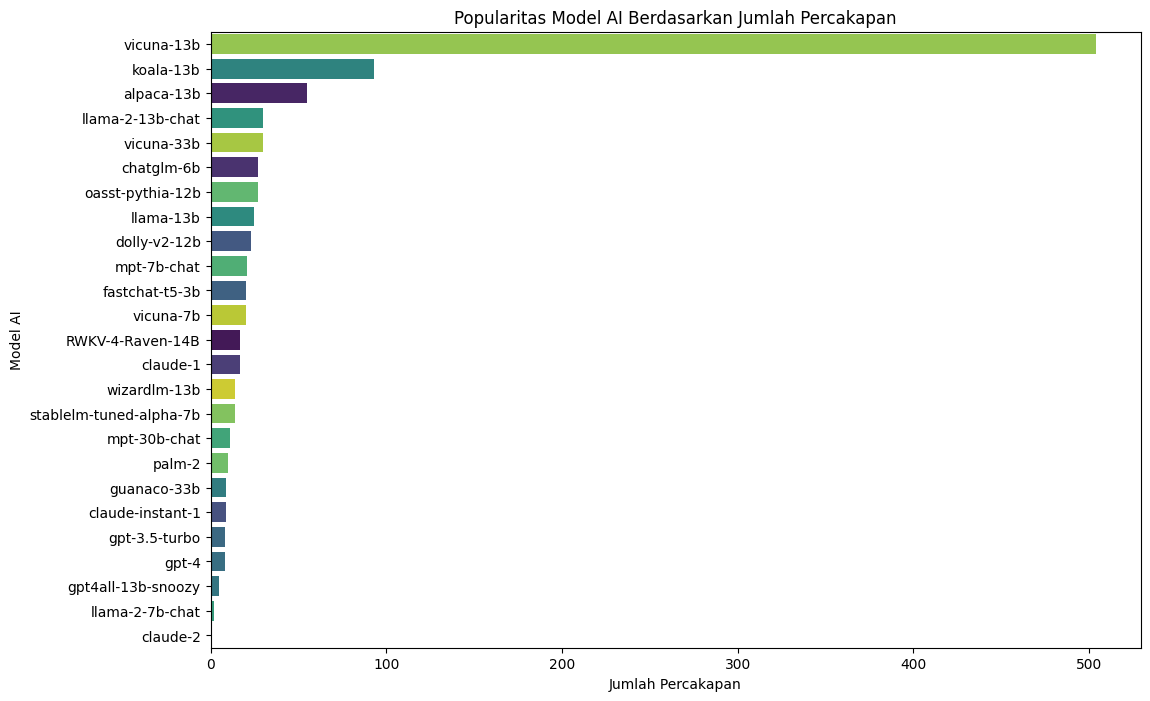

In [112]:
plt.figure(figsize=(12, 8))
sns.countplot(
    y=df['model'], 
    order=df['model'].value_counts().index, 
    palette='viridis',
    hue=df['model'], 
    legend=False 
)
plt.title('Popularitas Model AI Berdasarkan Jumlah Percakapan')
plt.xlabel('Jumlah Percakapan')
plt.ylabel('Model AI')
plt.show()

## Pertanyaan 2: Analisis Topik Percakapan
Apa saja topik atau jenis tugas yang paling sering diminta oleh pengguna kepada model-model AI tersebut (misalnya: pemrograman, penulisan kreatif, tanya jawab umum)?

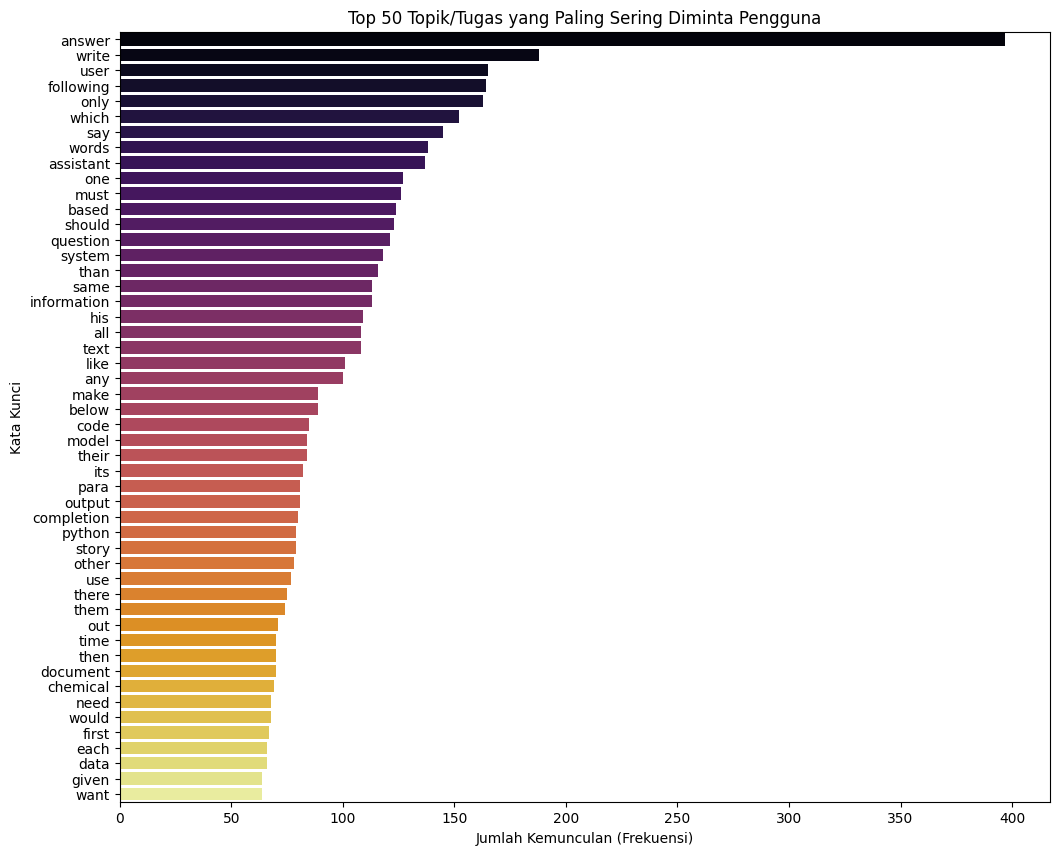

In [113]:
# 1. Ekstrak semua teks dari peran 'user'
user_texts = []
for conv in df['conversation']:
    for message in conv:
        if message['role'] == 'user':
            user_texts.append(message['content'])

# 2. Gabungkan semua teks menjadi satu string besar dan bersihkan
full_text = ' '.join(user_texts).lower()
# Hapus semua karakter non-alfanumerik kecuali spasi
full_text = re.sub(r'[^\w\s]', '', full_text)

# 3. Pisahkan menjadi kata-kata dan hapus stopwords (kata umum dalam Bahasa Inggris)
# Daftar stopwords sederhana untuk analisis ini
stopwords = set([
    'the', 'a', 'an', 'in', 'is', 'it', 'of', 'and', 'to', 'for', 'on', 'with', 'that', 'this',
    'i', 'you', 'me', 'my', 'what', 'who', 'when', 'where', 'why', 'how', 'can', 'please',
    'tell', 'give', 'about', 'some', 'do', 'does', 'did', 'are', 'was', 'were', 'be', 'die', 'name',
    'your', 'new', 'more', 'from', 'her', 'will', 'been', 'but', 'has', 'they', 'he', 'not', 'que',
    'name_1', 'name_2', 'have', 'she', 'name_3'
])

words = [word for word in full_text.split() if word not in stopwords and len(word) > 2]

# 4. Hitung 50 kata kunci yang paling umum
word_counts = Counter(words)
top_50_words = word_counts.most_common(50)

# Ubah ke DataFrame untuk plotting
df_top_words = pd.DataFrame(top_50_words, columns=['Kata Kunci', 'Frekuensi'])

# 5. Buat visualisasi dengan diagram batang horizontal
plt.figure(figsize=(12, 10))
sns.barplot(
    x='Frekuensi', 
    y='Kata Kunci', 
    data=df_top_words, 
    palette='inferno',
    hue='Kata Kunci',  
    legend=False
)
plt.title('Top 50 Topik/Tugas yang Paling Sering Diminta Pengguna')
plt.xlabel('Jumlah Kemunculan (Frekuensi)')
plt.ylabel('Kata Kunci')
plt.show()

## Pertanyaan 3: Perbandingan Kualitas
Apakah ada perbedaan dalam panjang percakapan atau pola interaksi yang menunjukkan kepuasan pengguna terhadap model tertentu?

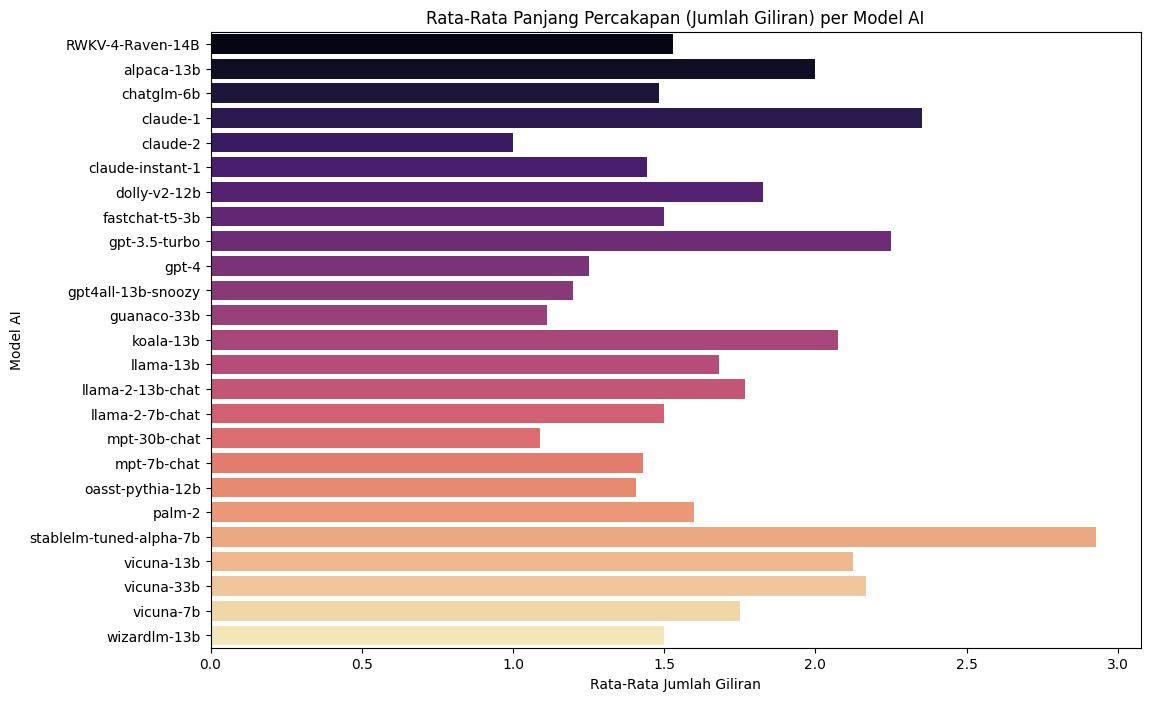

In [114]:
# Tambahkan observed=False untuk menghilangkan peringatan pandas
avg_turns_by_model = df.groupby('model', observed=False)['turn'].mean().sort_values(ascending=False)

# Membuat plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x=avg_turns_by_model.values,
    y=avg_turns_by_model.index,
    palette='magma',
    hue=avg_turns_by_model.index, 
    legend=False 
)
plt.title('Rata-Rata Panjang Percakapan (Jumlah Giliran) per Model AI')
plt.xlabel('Rata-Rata Jumlah Giliran')
plt.ylabel('Model AI')
plt.show()

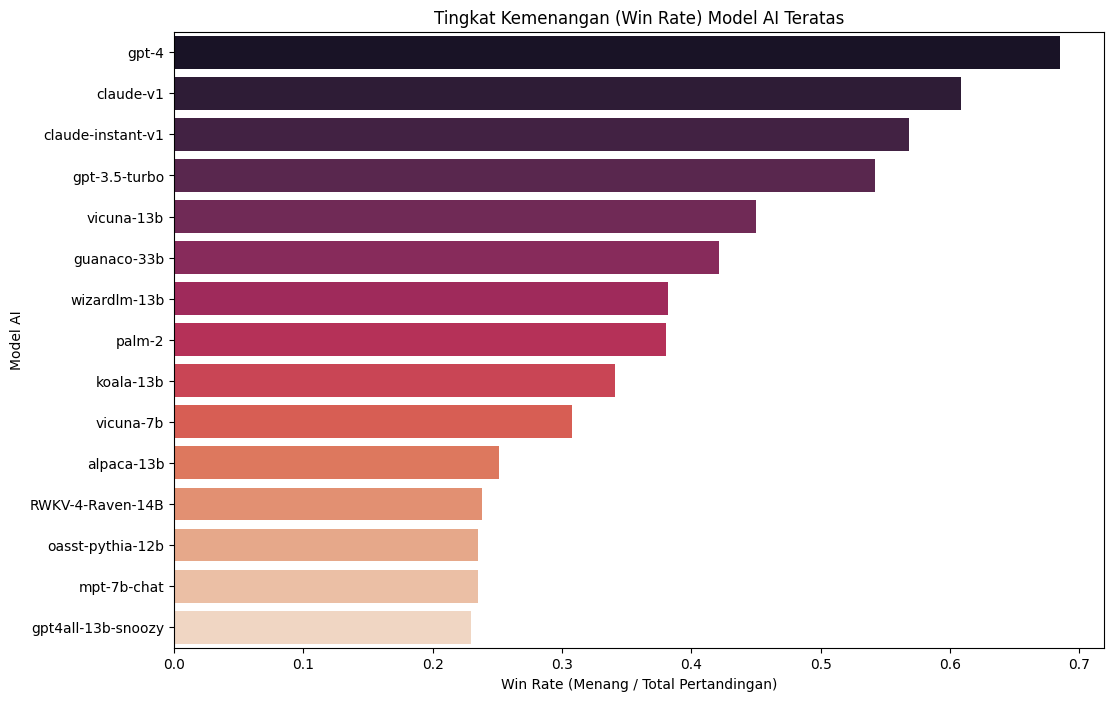

In [115]:
# Memuat dataset baru yang berisi data voting/preferensi pengguna
arena_dataset = load_dataset("lmsys/chatbot_arena_conversations", split='train')
df_arena = pd.DataFrame(arena_dataset)

# Menghitung jumlah kemenangan untuk model A dan model B
wins_a = df_arena[df_arena['winner'] == 'model_a']['model_a'].value_counts()
wins_b = df_arena[df_arena['winner'] == 'model_b']['model_b'].value_counts()

# Menggabungkan total kemenangan
total_wins = wins_a.add(wins_b, fill_value=0)

# Menghitung total berapa kali setiap model muncul (bertanding)
appearances_a = df_arena['model_a'].value_counts()
appearances_b = df_arena['model_b'].value_counts()
total_appearances = appearances_a.add(appearances_b, fill_value=0)

# Menghitung win rate (tingkat kemenangan)
win_rate = (total_wins / total_appearances).sort_values(ascending=False)

# Mengambil 15 model teratas untuk visualisasi
top_15_win_rate = win_rate.nlargest(15)

# Membuat plot untuk win rate
plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_15_win_rate.values,
    y=top_15_win_rate.index,
    palette='rocket',
    hue=top_15_win_rate.index, 
    legend=False 
)
plt.title('Tingkat Kemenangan (Win Rate) Model AI Teratas')
plt.xlabel('Win Rate (Menang / Total Pertandingan)')
plt.ylabel('Model AI')
plt.show()

## Pertanyaan 4: Turns-to-Solve (TTS)
TTS = jumlah **turn** pada percakapan yang terdeteksi “beres” (proxy sinyal bahasa user).  
Semakin rendah TTS → semakin efisien model menyelesaikan tugas.


In [116]:
# Hanya gunakan percakapan yang berstatus 'solved' menurut proxy
df_solved = df[df["is_solved"]].copy()

if df_solved.empty:
    print("Belum ada percakapan yang terdeteksi 'beres' (sesuai filter/data saat ini).")
else:
    tts_stats = (
    df_solved
    .groupby("model", observed=True)["turn"]
    .agg(n_solved="count", mean="mean", median="median", p75=lambda s: s.quantile(0.75))
    .sort_values("median")
    .round(2)
    )
    tts_stats


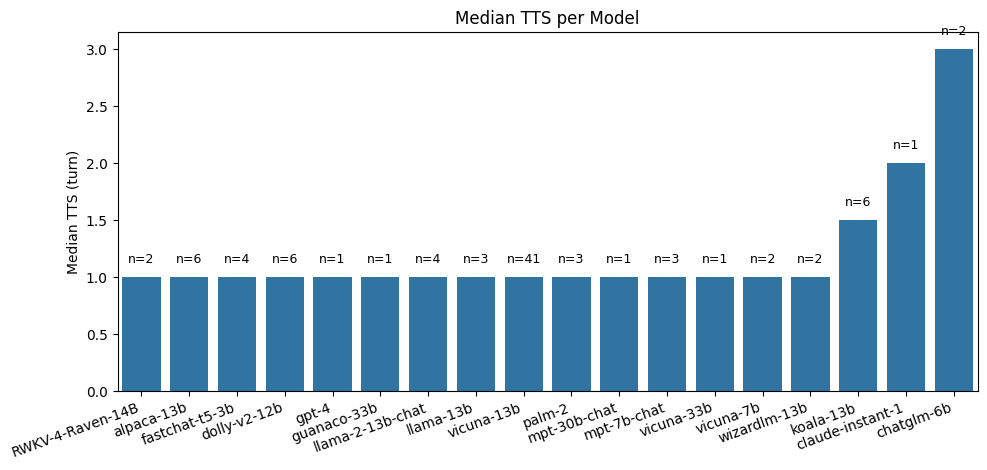

In [117]:
# Plot bar Median TTS per model + anotasi n_solved
import matplotlib.pyplot as plt
import seaborn as sns

if "tts_stats" not in globals() or tts_stats is None or tts_stats.empty:
    print("Belum ada data TTS untuk diplot.")
else:
    # pastikan urutan sumbu X konsisten
    order = tts_stats.index.tolist()

    fig, ax = plt.subplots(figsize=(10, 4.8))
    sns.barplot(x=tts_stats.index, y=tts_stats["median"], order=order, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("Median TTS (turn)")
    ax.set_title("Median TTS per Model")
    plt.xticks(rotation=20, ha="right")

    # anotasi jumlah percakapan solved (n_solved) di atas tiap bar
    for i, (median_val, n_val) in enumerate(
        zip(tts_stats.loc[order, "median"], tts_stats.loc[order, "n_solved"])
    ):
        ax.text(i, float(median_val) + 0.1, f"n={int(n_val)}",
                ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()


## Pertanyaan 5: Fit-for-Purpose (Model × Topik)
Metrik = **Solved Rate (proxy)** per kombinasi *model × kategori topik*.  
Gunakan untuk *routing* otomatis (pilih model sesuai tugas) dan bahan paket bundling (mis. Pro-Coding vs Pro-Writing).


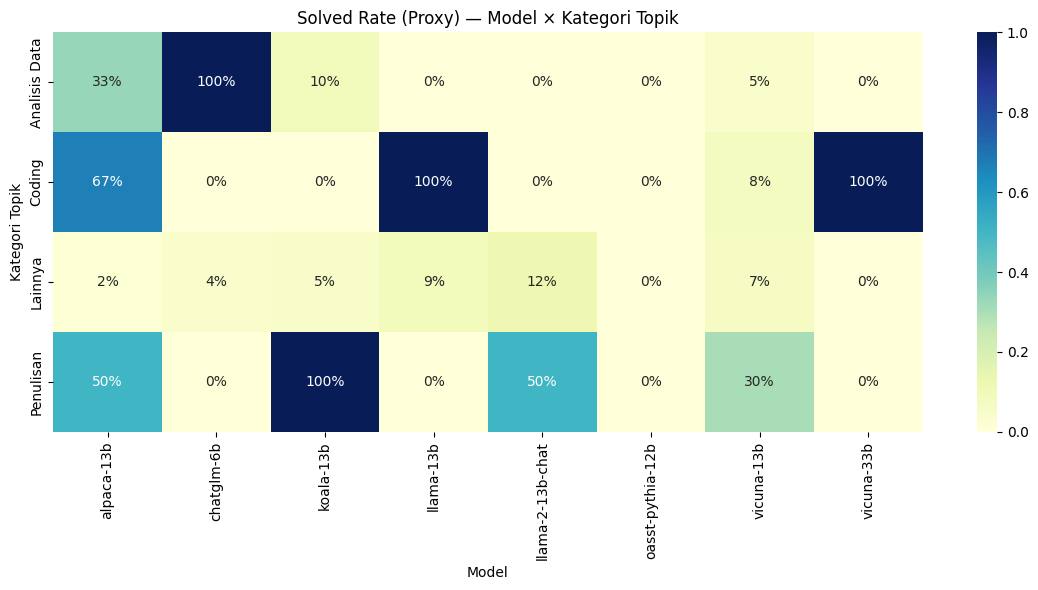

In [118]:
# Batasi ke Top-N model agar heatmap ringkas
TOP_N_HEAT = 8
top_models = df["model"].value_counts().head(TOP_N_HEAT).index

perf = (
    df[df["model"].isin(top_models)]
    .groupby(["topic_category", "model"], observed=True)
    .agg(n=("model", "size"), solved_rate=("is_solved", "mean"))
    .reset_index()
)

heat = perf.pivot(index="topic_category", columns="model", values="solved_rate")

import seaborn as sns, matplotlib.pyplot as plt

if heat.empty:
    print("Data tidak mencukupi untuk membuat heatmap.")
else:
    plt.figure(figsize=(min(12, 2 + 1.2*len(heat.columns)), 6))
    sns.heatmap(
        heat.fillna(0),
        cmap="YlGnBu",
        vmin=0, vmax=1,
        annot=True, fmt=".0%"
    )
    plt.title("Solved Rate (Proxy) — Model × Kategori Topik")
    plt.xlabel("Model")
    plt.ylabel("Kategori Topik")
    plt.tight_layout()
    plt.show()


In [119]:
MIN_N = 30  # naikkan jika dataset besar
leaders = (
    perf[perf["n"] >= MIN_N]
    .sort_values(["topic_category", "solved_rate"], ascending=[True, False])
    .groupby("topic_category", observed=True)
    .head(1)
    .reset_index(drop=True)
)

if leaders.empty:
    print(f"Belum ada kombinasi model×topik dengan N ≥ {MIN_N}.")
else:
    leaders.assign(solved_rate=(leaders["solved_rate"]*100).round(1)) \
           .rename(columns={"topic_category":"Topik", "model":"Model", "n":"N", "solved_rate":"Solved Rate (%)"})


In [120]:
# === Auto-generate CONCLUSION 1–5 (sel baru di bawah heading CONCLUSION) ===
from IPython.display import Markdown, display
import pandas as pd, numpy as np, re

def _safe_percent(x):
    try:
        return f"{float(x)*100:.1f}%"
    except Exception:
        return "—"

def _fmt_list(items, limit=None):
    items = list(items)
    if limit is not None:
        items = items[:limit]
    return ", ".join(items)

lines = []

# 1) Popularitas model (pakai countplot data yang sama: df['model'].value_counts())
try:
    vc = df["model"].value_counts(dropna=False)
    top5 = vc.head(5)
    total = int(vc.sum())
    top5_share = float(top5.sum())/total if total else np.nan
    popular_line = f"Top-5 model menyumbang **{_safe_percent(top5_share)}** dari **{total:,}** percakapan: " + \
                   _fmt_list([f"**{m}** ({c:,})" for m, c in top5.items()])
except Exception:
    popular_line = "Data model tidak tersedia."
lines.append(f"**1) Popularitas model.** {popular_line}")

# 2) Topik/Tugas dominan (pakai df_top_words dari chart topik)
try:
    if "df_top_words" in globals() and not df_top_words.empty:
        top_keywords = df_top_words.head(10)["Kata Kunci"].tolist()
        topics_line = "Kata kunci yang paling sering muncul: " + _fmt_list([f"**{w}**" for w in top_keywords])
    else:
        # fallback ringan (tanpa stopwords rumit)
        user_texts=[]
        for conv in df["conversation"]:
            for msg in conv:
                if msg.get("role")=="user":
                    user_texts.append((msg.get("content") or "").lower())
        text=" ".join(user_texts)
        words = re.findall(r"[a-zA-Z]{3,}", text)
        from collections import Counter
        ctr = Counter(words)
        top_keywords = [w for w,_ in ctr.most_common(10)]
        topics_line = "Kata kunci teratas: " + _fmt_list([f"**{w}**" for w in top_keywords])
except Exception:
    topics_line = "Ringkasan topik tidak tersedia."
lines.append(f"**2) Topik/Tugas dominan.** {topics_line}")

# 3) Pola interaksi & preferensi (win-rate vs panjang percakapan)
try:
    win_series = None
    if "top_15_win_rate" in globals():
        win_series = top_15_win_rate
    elif "win_rate" in globals():
        win_series = win_rate
    if win_series is not None and len(win_series)>0:
        leader = win_series.idxmax()
        leader_val = float(win_series.max())
        corr_txt = ""
        if "avg_turns_by_model" in globals():
            # Spearman via ranking
            common = win_series.index.intersection(avg_turns_by_model.index)
            if len(common) >= 5:
                corr = win_series.loc[common].rank().corr(
                    avg_turns_by_model.loc[common].rank(), method="pearson"
                )
                trend = ("negatif (win-rate tinggi ↘ panjang percakapan)" if corr < -0.1
                         else "positif (win-rate tinggi ↗ panjang percakapan)" if corr > 0.1
                         else "lemah/tidak jelas")
                corr_txt = f" Korelasi (Spearman, estimasi): **{corr:.2f}** → {trend}."
        win_line = f"Pemimpin win-rate: **{leader}** (**{leader_val:.2f}**).{corr_txt}"
    else:
        win_line = "Data win-rate tidak tersedia di sesi ini."
except Exception:
    win_line = "Ringkasan win-rate tidak tersedia."
lines.append(f"**3) Pola interaksi & preferensi.** {win_line}")

# 4) Efisiensi penyelesaian (TTS) — median turn untuk percakapan 'beres'
try:
    tts_line = ""
    # Jika belum ada, coba hitung cepat dari df
    if "tts_stats" not in globals() or tts_stats is None or tts_stats.empty:
        OK_PAT = re.compile(r"(thanks|thank you|terima kasih|berhasil|works|solved|mantap|fixed?|oke+|ok\\s*(udah|siap)?|sip|resolved)", re.I)
        def _is_solved(conv):
            for msg in reversed(conv):
                if msg.get("role")=="user":
                    return bool(OK_PAT.search((msg.get("content") or "").lower()))
            return False
        df_ = df.copy()
        if "turn" not in df_.columns:
            df_["turn"] = df_["conversation"].apply(lambda conv: len(conv) if isinstance(conv, (list,tuple)) else np.nan)
        df_["is_solved"] = df_.get("is_solved", pd.Series([_is_solved(c) for c in df_["conversation"]]))
        df_solved_ = df_[df_["is_solved"]]
        tts_stats = (
            df_solved_.groupby("model", observed=True)["turn"]
            .agg(n_solved="count", median="median", mean="mean")
            .sort_values("median")
        )
    # Ambang keandalan
    MIN_N = 30
    best_tts = tts_stats[tts_stats["n_solved"] >= MIN_N].head(3)
    if best_tts.empty:
        tts_line = f"Belum cukup percakapan 'beres' (N≥{MIN_N}) untuk pembandingan TTS."
    else:
        parts = [f"**{idx}** (median **{row['median']:.1f}** turn; n={int(row['n_solved'])})"
                 for idx, row in best_tts.iterrows()]
        tts_line = "Model dengan TTS terbaik: " + "; ".join(parts)
except Exception:
    tts_line = "Ringkasan TTS tidak tersedia."
lines.append(f"**4) Efisiensi penyelesaian (TTS).** {tts_line}")

# 5) Fit-for-purpose (Model × Topik) — juara per topik berdasar solved rate
try:
    fit_line = ""
    if "leaders" in globals() and leaders is not None and not leaders.empty:
        rows = leaders.copy()
    else:
        # hitung cepat bila variabel belum ada (butuh topic_category & is_solved)
        df_ = df.copy()
        if "topic_category" not in df_.columns:
            # fallback rule-based ringan
            TOPIC_RULES = {
                "Coding": re.compile(r"\\b(code|coding|bug|function|class|method|api|regex|python|javascript|java|typescript|ts|cpp|golang|php|html|css|framework|compile|error)\\b", re.I),
                "Analisis Data": re.compile(r"\\b(data|dataset|pandas|numpy|stat(istik|s)?|regression|cluster|model(ing)?|visualisasi|plot|chart|csv|etl|eda)\\b", re.I),
                "Terjemahan": re.compile(r"\\b(translate|translat(e|ion)|terjemah|alih ?bahasa|english to indonesian|indonesian to english|b\\.?inggris|b\\.?indonesia)\\b", re.I),
                "Penulisan": re.compile(r"\\b(tulis|menulis|writing|essay|artikel|copy|caption|paragraf|ringkas|rangkuman|summary|email|surat|konten)\\b", re.I),
            }
            def _user_text(conv):
                return " ".join([(m.get("content") or "") for m in conv if m.get("role")=="user"])
            def _topic(text):
                for label in ["Coding","Analisis Data","Terjemahan","Penulisan"]:
                    if TOPIC_RULES[label].search(text):
                        return label
                return "Lainnya"
            df_["user_text"] = df_["conversation"].apply(_user_text)
            df_["topic_category"] = df_["user_text"].apply(_topic)
        if "is_solved" not in df_.columns:
            OK_PAT = re.compile(r"(thanks|thank you|terima kasih|berhasil|works|solved|mantap|fixed?|oke+|ok\\s*(udah|siap)?|sip|resolved)", re.I)
            def _is_solved(conv):
                for msg in reversed(conv):
                    if msg.get("role")=="user":
                        return bool(OK_PAT.search((msg.get("content") or "").lower()))
                return False
            df_["is_solved"] = df_["conversation"].apply(_is_solved)
        TOP_N_HEAT = 8
        top_models = df_["model"].value_counts().head(TOP_N_HEAT).index
        perf = (
            df_[df_["model"].isin(top_models)]
            .groupby(["topic_category","model"], observed=True)
            .agg(n=("model","size"), solved_rate=("is_solved","mean"))
            .reset_index()
        )
        MIN_N = 30
        rows = (
            perf[perf["n"]>=MIN_N]
            .sort_values(["topic_category","solved_rate"], ascending=[True,False])
            .groupby("topic_category", observed=True)
            .head(1)
        )
    if rows is None or rows.empty:
        fit_line = "Belum cukup data (N≥30) untuk menentukan juara per topik."
    else:
        items = [f"**{r['topic_category']}** → **{r['model']}** (Solved Rate **{r['solved_rate']*100:.1f}%**, N={int(r['n'])})"
                 for _, r in rows.iterrows()]
        fit_line = "; ".join(items)
except Exception:
    fit_line = "Ringkasan fit-for-purpose tidak tersedia."
lines.append(f"**5) Kecocokan model per topik (fit-for-purpose).** {fit_line}")

md = "## CONCLUSION (Terbarui)\n\n" + "\n\n".join(lines) + \
     "\n\n> Catatan: angka mengikuti filter/sampel yang aktif. Gunakan ambang **N≥30** sebagai patokan keandalan."
display(Markdown(md))


## CONCLUSION (Terbarui)

**1) Popularitas model.** Top-5 model menyumbang **71.2%** dari **1,000** percakapan: **vicuna-13b** (504), **koala-13b** (93), **alpaca-13b** (55), **llama-2-13b-chat** (30), **vicuna-33b** (30)

**2) Topik/Tugas dominan.** Kata kunci yang paling sering muncul: **answer**, **write**, **user**, **following**, **only**, **which**, **say**, **words**, **assistant**, **one**

**3) Pola interaksi & preferensi.** Pemimpin win-rate: **gpt-4** (**0.68**). Korelasi (Spearman, estimasi): **0.28** → positif (win-rate tinggi ↗ panjang percakapan).

**4) Efisiensi penyelesaian (TTS).** Model dengan TTS terbaik: **vicuna-13b** (median **1.0** turn; n=41)

**5) Kecocokan model per topik (fit-for-purpose).** **Coding** → **vicuna-13b** (Solved Rate **7.5%**, N=80); **Lainnya** → **vicuna-13b** (Solved Rate **7.1%**, N=379)

> Catatan: angka mengikuti filter/sampel yang aktif. Gunakan ambang **N≥30** sebagai patokan keandalan.